The EOP file 'finals2000A.all' in C:\Users\Lorenzo/src/iers/ is already the latest.
The Leap Second file 'Leap_Second.dat' in C:\Users\Lorenzo/src/iers/ is already the latest.
Starting HD windows time step [s]: []
HD windows duration [s]: []
Timestep 3600.0000 ss
Run time 45.01s/0.75m


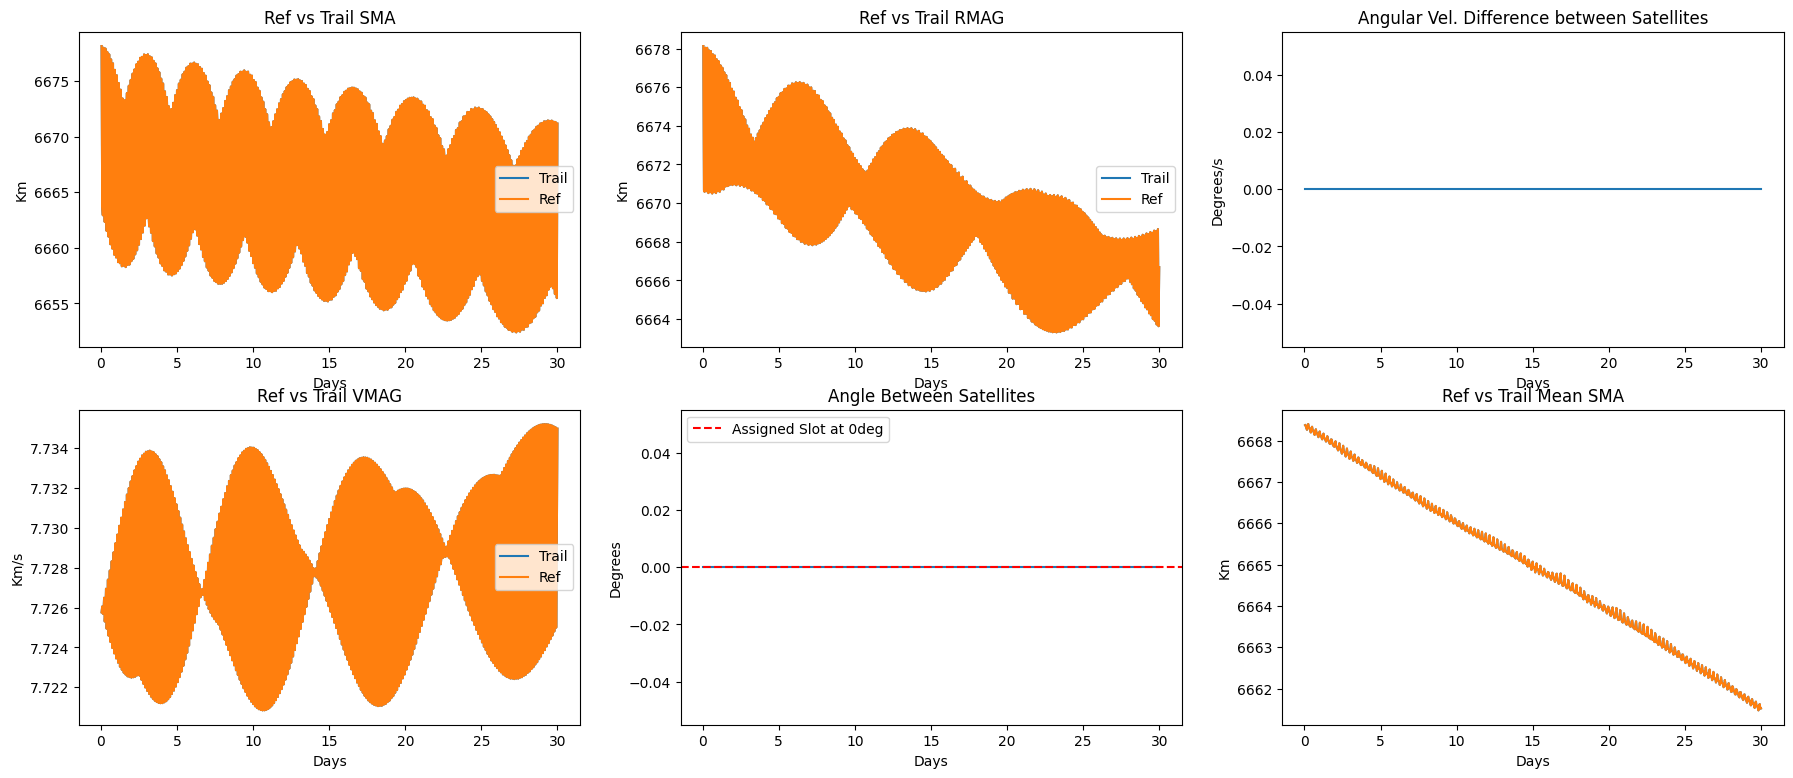

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import time

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.util import norm
from poliastro.constants import R_earth
from poliastro.core.elements import coe2rv
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime
from sso_inc import inc_from_alt, raan_from_ltan,angle_between

from perturbations import perturbations_coesa_J2_low, perturbations_coesa_J2_high

from osc2mean_dd import osc2mean


toc = time.time()

## Orbit
h = 300
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

delta_a = 0
delta_nu = 0

reference_orbit = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch
    )
trailing_orbit = Orbit.from_classical(
    Earth,
    (a.value+delta_a)<<u.km,
    ecc,
    inc,
    raan,
    argp,
    (nu.value+delta_nu)<<u.deg,
    epoch
    )


time_step = 3600<<u.s
assignment = 0%360
pred_days = 10

refsmalist = []
refsmalist_mean = []
trailsmalist = []
trailsmalist_mean = []



ref_vel = []
trail_vel = []
elapsedsecs = []
secs = 0
rmag_ref = []
rmag_trail = []
vmag_ref = []
vmag_trail = []
angle_list = []
ang_vel_list = []
theta_err_list = []
mean_ang_list = []
hd_window = []
hd_duration = []

start_date_prop = epoch
ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
trail_mean = osc2mean(a.value+delta_a, ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu)
trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu<<u.deg), epoch)

t_prop = (60*60*24*30)<<u.s
num_prop = int(t_prop.value / time_step.value)
tofs_prop = TimeDelta(np.linspace(0, t_prop, num=num_prop))

reference_ephem = reference_orbit.to_ephem(EpochsArray(reference_orbit.epoch + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
trailing_ephem = trailing_orbit.to_ephem(EpochsArray(trailing_orbit.epoch + tofs_prop, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))

for t in range(len(tofs_prop)):

    secs += time_step.value

    ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem, reference_ephem.epochs[t])
    trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem, trailing_ephem.epochs[t])

    refsmalist.append(ref_from_ephem.a.value)
    trailsmalist.append(trail_from_ephem.a.value)

    ref_mean = osc2mean(
        ref_from_ephem.a.value,
        ref_from_ephem.ecc.value,
        ref_from_ephem.inc.to_value(u.deg),
        ref_from_ephem.raan.to_value(u.deg),
        ref_from_ephem.argp.to_value(u.deg),
        ref_from_ephem.nu.to_value(u.deg)

    )
    trail_mean = osc2mean(
        trail_from_ephem.a.value,
        trail_from_ephem.ecc.value,
        trail_from_ephem.inc.to_value(u.deg),
        trail_from_ephem.raan.to_value(u.deg),
        trail_from_ephem.argp.to_value(u.deg),
        trail_from_ephem.nu.to_value(u.deg)
    )

    refsmalist_mean.append(ref_mean[0])
    trailsmalist_mean.append(trail_mean[0])

    rmag_ref.append(np.linalg.norm(ref_from_ephem.r.value))
    rmag_trail.append(np.linalg.norm(trail_from_ephem.r.value))  

    vmag_ref.append(np.linalg.norm(ref_from_ephem.v.value))
    vmag_trail.append(np.linalg.norm(trail_from_ephem.v.value))
    
    angle_list.append(angle_between(trail_from_ephem.r.value, ref_from_ephem.r.value))

    ang_vel_ref = (360 << u.deg) / ref_from_ephem.period
    ang_vel_trail = (360 <<u.deg) / trail_from_ephem.period
    ang_vel_diff =  ang_vel_ref - ang_vel_trail
    ang_vel_list.append(ang_vel_diff.value)

    elapsedsecs.append(secs)



elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

fig, ax = plt.subplots(2, 3, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,trailsmalist,label='Trail')
ax[0,0].plot(elapsed_days,refsmalist,label='Ref')
ax[0,0].legend(loc = 'center right')
ax[0,0].set_title('Ref vs Trail SMA')
ax[0,0].set_xlabel('Days')
ax[0,0].set_ylabel('Km')

ax[0,1].plot(elapsed_days,rmag_trail,label='Trail')
ax[0,1].plot(elapsed_days,rmag_ref,label='Ref')
ax[0,1].legend(loc = 'center right')
ax[0,1].set_title('Ref vs Trail RMAG')
ax[0,1].set_xlabel('Days')
ax[0,1].set_ylabel('Km')

ax[1,0].plot(elapsed_days,vmag_trail,label='Trail')
ax[1,0].plot(elapsed_days,vmag_ref, label='Ref')
ax[1,0].legend(loc = 'center right')
ax[1,0].set_title('Ref vs Trail VMAG')
ax[1,0].set_xlabel('Days')
ax[1,0].set_ylabel('Km/s')

ax[1,1].plot(elapsed_days,angle_list)
ax[1,1].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[1,1].legend(loc = 'upper left')
ax[1,1].set_title('Angle Between Satellites')
ax[1,1].set_xlabel('Days')
ax[1,1].set_ylabel('Degrees')

ax[0,2].plot(elapsed_days,ang_vel_list)
ax[0,2].set_title('Angular Vel. Difference between Satellites')
ax[0,2].set_xlabel('Days')
ax[0,2].set_ylabel('Degrees/s')

ax[1,2].plot(elapsed_days,trailsmalist_mean,label='Trail')
ax[1,2].plot(elapsed_days,refsmalist_mean,label='Ref')
ax[1,2].set_title('Ref vs Trail Mean SMA')
ax[1,2].set_xlabel('Days')
ax[1,2].set_ylabel('Km')


print(f'Starting HD windows time step [s]: {hd_window}')
print(f'HD windows duration [s]: {hd_duration}')

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()



In [2]:
Earth.R

<Quantity 6378136.6 m>

In [3]:
Earth.R_mean

<Quantity 6371008.4 m>

In [5]:
for i in range(1):
    print('ok')

ok
